In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install kaggle

In [2]:
!pip install facenet_pytorch --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 23.4 MB/s eta 0:00:00


In [3]:
import os
import random
import datetime
import sys
import itertools
import os.path
import time
import glob
import subprocess
import shutil
from pathlib import Path
from collections import Counter
import gc
import math
from typing import List, Dict, Tuple, Union

from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt


import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from facenet_pytorch import MTCNN
from torch.nn import functional
import torchvision.models as models
import cv2


import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"vasylhunia","key":"ac16ba802a4f035043401d0f06d03422"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [5]:
from kaggle.api.kaggle_api_extended import KaggleApi


api = KaggleApi()
api.authenticate()
api.dataset_download_files('kangjiayong/deepfake-detection', path='./data', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/kangjiayong/deepfake-detection


In [56]:
def convert_path(path: str) -> str:
    for i in range(10):
        path = path.replace(f'{i:02}', str(i))
    return path


def process_file_paths(df: pd.DataFrame) -> List[Tuple[str, str]]:
    result: List[Tuple[str, str]] = []

    for _, row in df.iterrows():
        file_name = row['path']

        path_parts = file_name.split('\\')
        curr_path = path_parts[-1].replace('.zip', '')
        file_path = os.path.join('/content/data', row['label'], row['label'], convert_path(curr_path), row['file_name'])

        result.append((file_path, row['label']))

    return result


df = pd.read_csv('/content/data/selected_video.csv')
result = process_file_paths(df)
result

[('/content/data/FAKE/FAKE/dfdc_train_part_9/qudhlvaxtc.mp4', 'FAKE'),
 ('/content/data/FAKE/FAKE/dfdc_train_part_4/jzxzzmcplq.mp4', 'FAKE'),
 ('/content/data/FAKE/FAKE/dfdc_train_part_1/pydbvfkslp.mp4', 'FAKE'),
 ('/content/data/FAKE/FAKE/dfdc_train_part_8/vytklfqusv.mp4', 'FAKE'),
 ('/content/data/FAKE/FAKE/dfdc_train_part_1/dbzpqxlahq.mp4', 'FAKE'),
 ('/content/data/FAKE/FAKE/dfdc_train_part_7/uqkdiusxtz.mp4', 'FAKE'),
 ('/content/data/FAKE/FAKE/dfdc_train_part_1/snphlfsrmr.mp4', 'FAKE'),
 ('/content/data/FAKE/FAKE/dfdc_train_part_4/ohofmyydou.mp4', 'FAKE'),
 ('/content/data/FAKE/FAKE/dfdc_train_part_6/mhodpmscfi.mp4', 'FAKE'),
 ('/content/data/FAKE/FAKE/dfdc_train_part_4/hfhgtkuaxr.mp4', 'FAKE'),
 ('/content/data/FAKE/FAKE/dfdc_train_part_9/njgymtktgd.mp4', 'FAKE'),
 ('/content/data/FAKE/FAKE/dfdc_train_part_1/sclvdumbkh.mp4', 'FAKE'),
 ('/content/data/FAKE/FAKE/dfdc_train_part_1/lnfcazoshs.mp4', 'FAKE'),
 ('/content/data/FAKE/FAKE/dfdc_train_part_4/pwduwistqx.mp4', 'FAKE'),
 ('/co

In [57]:
import pandas as pd


df = pd.DataFrame(result, columns=['video_path', 'label'])


print(len(df['video_path'].unique()))
print(len(df['label'].unique()))

5024
2


<Axes: >

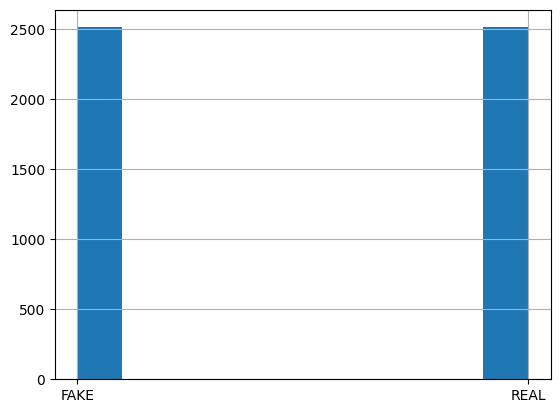

In [58]:
df['label'].hist()

In [59]:
train_data, test_data = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)


print("Кількість у тренувальному наборі:")
print(train_data['label'].value_counts())
print("\nКількість у тестовому наборі:")
print(test_data['label'].value_counts())

Кількість у тренувальному наборі:
label
REAL    2010
FAKE    2009
Name: count, dtype: int64

Кількість у тестовому наборі:
label
FAKE    503
REAL    502
Name: count, dtype: int64


In [60]:
train_data

,video_path,label
1614,/content/data/FAKE/FAKE/dfdc_train_part_5/wogc...,FAKE
4968,/content/data/REAL/REAL/dfdc_train_part_9/veya...,REAL
4579,/content/data/REAL/REAL/dfdc_train_part_8/fapk...,REAL
4606,/content/data/REAL/REAL/dfdc_train_part_8/mvkn...,REAL
4887,/content/data/REAL/REAL/dfdc_train_part_9/hlte...,REAL
...,...,...
1135,/content/data/FAKE/FAKE/dfdc_train_part_6/kqyv...,FAKE
3556,/content/data/REAL/REAL/dfdc_train_part_5/imrp...,REAL
4819,/content/data/REAL/REAL/dfdc_train_part_9/gtxp...,REAL
2163,/content/data/FAKE/FAKE/dfdc_train_part_6/tfup...,FAKE


In [61]:
train_data.to_csv("train_dataset.csv", index=False)
test_data.to_csv("test_dataset.csv", index=False)

In [62]:
def create_json_from_csv(input_csv: str, output_json: str) -> None:
    df = pd.read_csv(input_csv)
    result: Dict[str, str] = {}

    for _, row in df.iterrows():
        file_path = row['video_path']
        label = row['label']

        result[file_path] = {'label': label}

    with open(output_json, 'w') as json_file:
        json.dump(result, json_file, indent=4)


create_json_from_csv('train_dataset.csv', 'output_balenced_train.json')
create_json_from_csv('test_dataset.csv', 'output_balenced_test.json')

In [63]:
with open('output_balenced_train.json', 'r') as json_file:
    data = json.load(json_file)

label_counts = Counter()

for item in data.values():
    label_counts[item['label']] += 1

for label, count in label_counts.items():
    print(f"Label: {label}, Count: {count}")

Label: FAKE, Count: 2009
Label: REAL, Count: 2010


In [64]:
class VideoDataset(torch.utils.data.Dataset):
    def __init__(self, n_frames: int, df_path: str, device, cache_folder: str):
        self.n_frames = n_frames
        self.videos = []
        self.device = device if device is not None else torch.device("cpu")
        self.cache_folder = cache_folder
        self.detector = MTCNN(device=device, post_process=False)

        with open(df_path) as f:
            videos = json.load(f)
            videos = [(video, metadata) for (video, metadata) in videos.items()]
            self.videos += videos

        if self.cache_folder:
            os.makedirs(self.cache_folder, exist_ok=True)

    def __process_frame(self, frame, video_id, frame_idx):
        cache_path = os.path.join(self.cache_folder, f"{video_id}_frame{frame_idx}.pt") if self.cache_folder else None

        if cache_path and os.path.exists(cache_path):
            return torch.load(cache_path)

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        boxes, _ = self.detector.detect(frame, landmarks=False)

        if boxes is None:
            return None
        else:
            box = boxes[0]
            width = box[2] - box[0]
            height = box[3] - box[1]
            expand_x = width * 0.3 / 2
            expand_y = height * 0.3 / 2
            x1 = max(int(box[0] - expand_x), 0)
            y1 = max(int(box[1] - expand_y), 0)
            x2 = min(int(box[2] + expand_x), frame.shape[1])
            y2 = min(int(box[3] + expand_y), frame.shape[0])

            face = frame[y1:y2, x1:x2]
            face = cv2.resize(face, (224, 224))
            face = torch.from_numpy(face).permute(2, 0, 1).float() / 255.0

            if cache_path:
                torch.save(face, cache_path)

            return face

    def __getitem__(self, n):
        video, metadata = self.videos[n]

        video_id = os.path.splitext(os.path.basename(video))[0]
        cap = cv2.VideoCapture(video)

        frames = []
        frame_idx = 0
        while len(frames) < self.n_frames:
            ret, frame = cap.read()
            if not ret:
                break

            processed_frame = self.__process_frame(frame, video_id, frame_idx)
            if processed_frame is not None:
                frames.append(processed_frame)
            frame_idx += 1

        cap.release()
        frames = torch.stack(frames).to(self.device)

        label = 0.0
        if metadata['label'] == 'FAKE':
            label = 1.0

        return frames, torch.FloatTensor([label]).to(self.device)

    def __len__(self):
        return len(self.videos)

Label: tensor([1.], device='cuda:0')


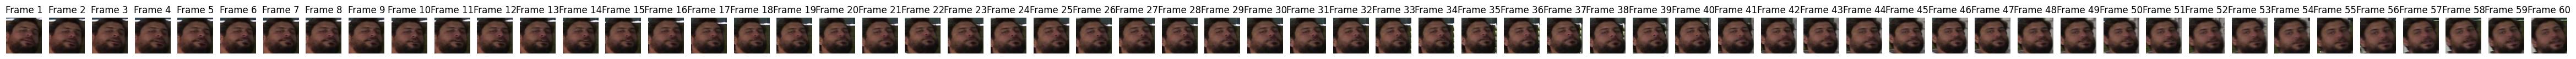

In [65]:
def test_train_data():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    dataset = VideoDataset(60, '/content/output_balenced_train.json', device, 'cache')

    for i, batch in enumerate(dataset):
        frames, label = batch
        print(f"Label: {label}")

        if frames.size() != torch.Size([60, 3, 224, 224]):
            print(f"Unexpected frame size: {frames.size()}")

        fig, axes = plt.subplots(1, 60, figsize=(60, 10))

        for j in range(60):
            ax = axes[j]
            frame = frames[j].cpu().permute(1, 2, 0).numpy()
            ax.imshow(frame)
            ax.set_title(f"Frame {j+1}")
            ax.axis('off')

        plt.show()
        break


test_train_data()

Label: tensor([0.], device='cuda:0')


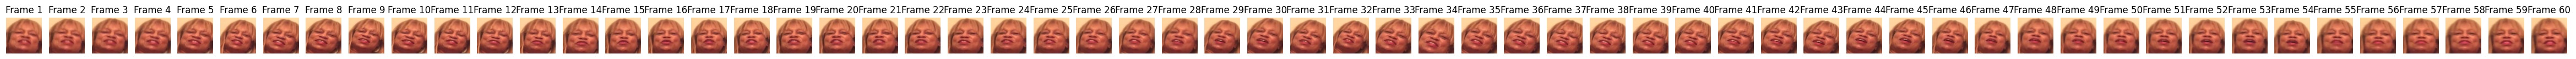

In [66]:
def test_test_data():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    dataset = VideoDataset(60, '/content/output_balenced_test.json', device, 'cache')

    for i, batch in enumerate(dataset):
        frames, label = batch
        print(f"Label: {label}")

        if frames.size() != torch.Size([60, 3, 224, 224]):
            print(f"Unexpected frame size: {frames.size()}")

        fig, axes = plt.subplots(1, 60, figsize=(60, 10))

        for j in range(60):
            ax = axes[j]
            frame = frames[j].cpu().permute(1, 2, 0).numpy()
            ax.imshow(frame)
            ax.set_title(f"Frame {j+1}")
            ax.axis('off')

        plt.show()
        break


test_test_data()

In [67]:
class CNNLSTMClassifier(nn.Module):
    def __init__(self, n_linear_hidden=256, lstm_hidden_dim=128, num_lstm_layers=1):
        super(CNNLSTMClassifier, self).__init__()

        self.cnn = models.efficientnet_b7(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(self.cnn.children())[:-1])

        for param in self.feature_extractor.parameters():
            param.requires_grad = False

        self.feature_output_size = 2560  # EfficientNet B7 дає 2560 ознак

        self.lstm = nn.LSTM(input_size=self.feature_output_size,
                            hidden_size=lstm_hidden_dim,
                            num_layers=num_lstm_layers,
                            batch_first=True,
                            bidirectional=True)

        self.fc1 = nn.Linear(2 * lstm_hidden_dim, n_linear_hidden)
        self.fc2 = nn.Linear(n_linear_hidden, 1)

    def forward(self, vid_frames):
        batch_size, num_frames, channels, height, width = vid_frames.shape
        vid_frames = vid_frames.view(batch_size * num_frames, channels, height, width)

        with torch.no_grad():
            vid_features = self.feature_extractor(vid_frames)

        vid_features = vid_features.view(batch_size, num_frames, -1)

        lstm_out, _ = self.lstm(vid_features)

        lstm_out = torch.mean(lstm_out, dim=1)

        x = torch.relu(self.fc1(lstm_out))
        x = self.fc2(x)

        return x

In [68]:
def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {title}')
    plt.show()


def plot_training_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()

    plt.show()


def plot_confusion_matrix_final(all_labels, all_preds, title):
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {title}')
    plt.show()

In [69]:
hyperparameters: dict[str: Union[int, float]] = {
    'n_linear_hidden': 256,
    'lstm_hidden_dim': 128,
    'num_lstm_layers': 1,
    'n_frames': 60,
    'batch_size': 8,
    'lr': 0.001,
    'num_epochs': 25,
}

In [70]:
def train_model(model, hparms: dict[str, Union[int, float]], path_train: str, path_test: str, device):
    batch_size = hparms['batch_size']
    num_epochs = hyperparameters['num_epochs']
    n_frames = hyperparameters['n_frames']
    lr = hyperparameters['lr']

    model.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_dataset = VideoDataset(n_frames, path_train, device, 'cache')
    test_dataset = VideoDataset(n_frames, path_test, device, 'cache')

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    start_time = datetime.datetime.now()
    print(f'Start time: {start_time}, using device: {device}')

    best_loss = np.inf
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    epoch_times = []

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        epoch_t_loss, epoch_v_loss = 0, 0
        t_count, t_count_wrong = 0, 0
        all_train_labels, all_train_preds = [], []

        model.train()
        torch.cuda.empty_cache()
        gc.collect()

        for video_data, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} Training", leave=False):
            video_data, labels = video_data.to(device), labels.to(device)

            optimizer.zero_grad()
            output = model(video_data)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            epoch_t_loss += loss.item()
            output = torch.sigmoid(output).round()
            n_wrong = (labels - output).abs().sum().item()
            t_count_wrong += n_wrong
            t_count += labels.shape[0]

            all_train_labels.extend(labels.detach().cpu().numpy())
            all_train_preds.extend(output.detach().cpu().numpy())

            torch.cuda.empty_cache()
            gc.collect()

        train_loss = epoch_t_loss / len(train_loader)
        train_accuracy = (t_count - t_count_wrong) / t_count
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        torch.cuda.empty_cache()
        gc.collect()
        all_val_labels, all_val_preds = [], []
        with torch.no_grad():
            for video_data, labels in tqdm(val_loader, desc="Validation", leave=False):
                video_data, labels = video_data.to(device), labels.to(device)

                output = model(video_data)
                loss = criterion(output, labels)
                epoch_v_loss += loss.item()

                output = torch.sigmoid(output).round()
                all_val_labels.extend(labels.cpu().numpy())
                all_val_preds.extend(output.cpu().numpy())

                torch.cuda.empty_cache()
                gc.collect()

        val_loss = epoch_v_loss / len(val_loader)
        val_accuracy = np.sum(np.array(all_val_labels) == np.array(all_val_preds)) / len(all_val_labels)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        epoch_exec_time = time.time() - epoch_start_time
        epoch_times.append(epoch_exec_time)
        print(f'Epoch {epoch + 1}/{num_epochs} - Train loss: {train_loss:.4f}, Train accuracy: {train_accuracy:.4f}')
        print(f'Validation loss: {val_loss:.4f}, Validation accuracy: {val_accuracy:.4f}, Time: {epoch_exec_time:.2f}s')

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), f'best_model_epoch_{epoch + 1}.pt')

    print(f'Training completed in: {str(datetime.datetime.now() - start_time)}')

    plot_training_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

    print("Train Classification Report:")
    print(classification_report(all_train_labels, all_train_preds))
    plot_confusion_matrix_final(all_train_labels, all_train_preds, 'Train')

    print("Validation Classification Report:")
    print(classification_report(all_val_labels, all_val_preds))
    plot_confusion_matrix_final(all_val_labels, all_val_preds, 'Validation')

In [71]:
model = CNNLSTMClassifier(
    n_linear_hidden=hyperparameters['n_linear_hidden'],
    lstm_hidden_dim=hyperparameters['lstm_hidden_dim'],
    num_lstm_layers=hyperparameters['num_lstm_layers']
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_model(model, hyperparameters, '/content/output_balenced_train.json', '/content/output_balenced_test.json', device)

Start time: 2024-11-13 18:02:30.245838, using device: cuda


KeyboardInterrupt: 